# Исследовательский анализ (EDA)

В данном ноутбуке проводится первичный анализ характеристик химических соединений и их антивирусной активности против вируса гриппа. Цель — выявить закономерности, выбросы и подготовить данные для дальнейшего моделирования.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [4]:
# загружаем данные и смотри первые 5 строк
df = pd.read_excel("data_ml.xlsx", engine="openpyxl")
df.head(5)

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# смотрим разер дата сета
df.shape

(1001, 214)

In [6]:
# смотрим столбцы с пропусками
df.columns[df.isna().any()].tolist()

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

In [7]:
# процент пропусков в столбце
columns_with_none = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI',
 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']  
(df[columns_with_none].isna().mean() * 100).round(4)

MaxPartialCharge       0.2997
MinPartialCharge       0.2997
MaxAbsPartialCharge    0.2997
MinAbsPartialCharge    0.2997
BCUT2D_MWHI            0.2997
BCUT2D_MWLOW           0.2997
BCUT2D_CHGHI           0.2997
BCUT2D_CHGLO           0.2997
BCUT2D_LOGPHI          0.2997
BCUT2D_LOGPLOW         0.2997
BCUT2D_MRHI            0.2997
BCUT2D_MRLOW           0.2997
dtype: float64

In [8]:
#Заполняем пропущенные значения медианой
df[columns_with_none] = df[columns_with_none].fillna(df[columns_with_none].median())

In [9]:
# проверяем что больше пропусков не осталось
df.columns[df.isna().any()].tolist()

[]

In [10]:
# Преобразуем значения в числовой формат
df[columns_with_none] = df[columns_with_none].apply(pd.to_numeric, errors='raise')
print("Все столбцы преобразованы")

Все столбцы преобразованы


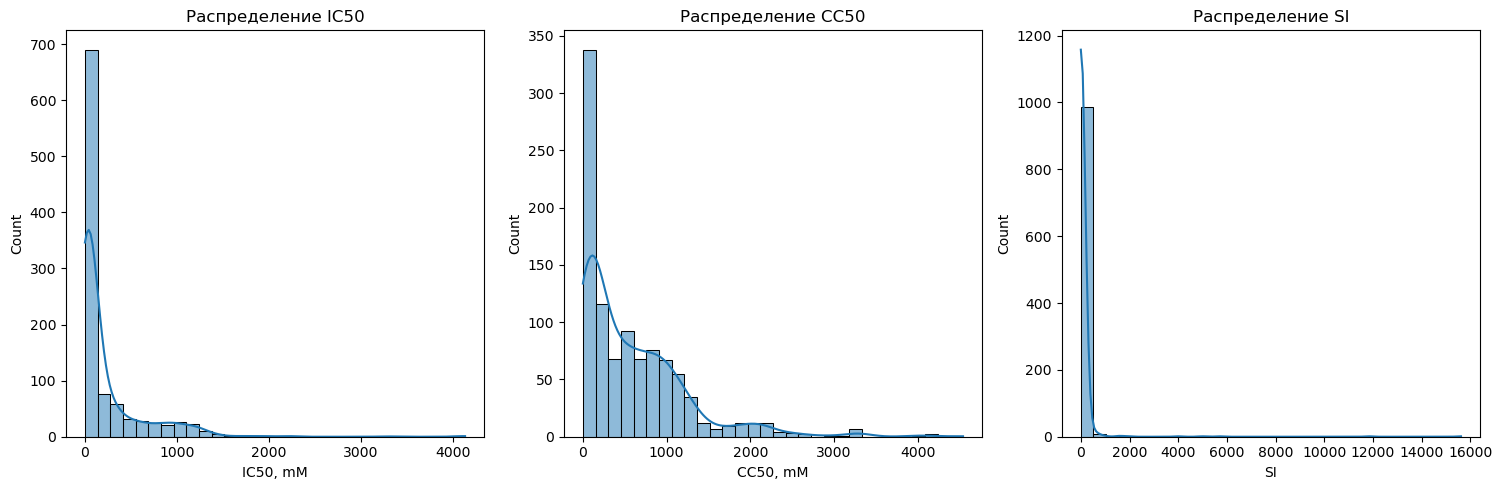

In [11]:
# Целевые переменные
target_cols = ['IC50, mM', 'CC50, mM', 'SI']
titles = ['Распределение IC50', 'Распределение CC50', 'Распределение SI']

plt.figure(figsize=(15, 5))

for i, (col, title) in enumerate(zip(target_cols, titles), 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(title)

plt.tight_layout()
plt.show()

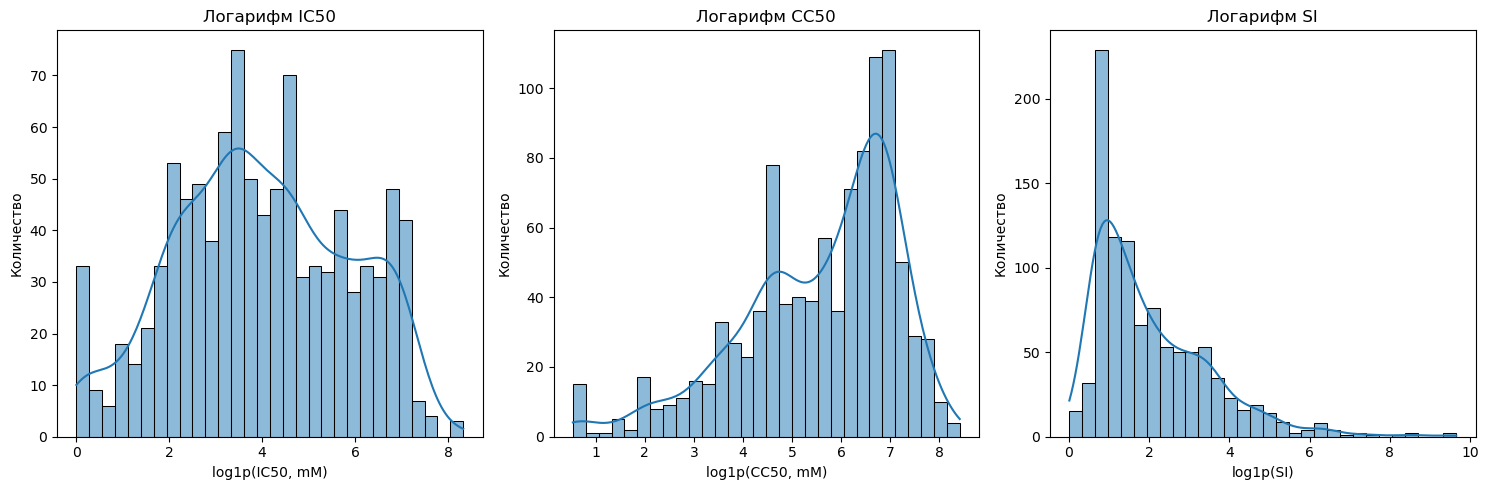

In [12]:
titles = ['Логарифм IC50', 'Логарифм CC50', 'Логарифм SI']

# Построение графиков
plt.figure(figsize=(15, 5))

for i, (col, title) in enumerate(zip(target_cols, titles), 1):
    plt.subplot(1, len(target_cols), i)
    sns.histplot(np.log1p(df[col]), kde=True, bins=30)
    plt.title(title)
    plt.xlabel(f"log1p({col})")
    plt.ylabel("Количество")

plt.tight_layout()
plt.show()


In [13]:
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print(f"Столбцы заполненые константой {constant_columns}")

Столбцы заполненые константой ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_thiocyan']


In [14]:
# Удаляем из датасета столбцы заполненые 1 значением
df = df.drop(constant_columns, axis=1)

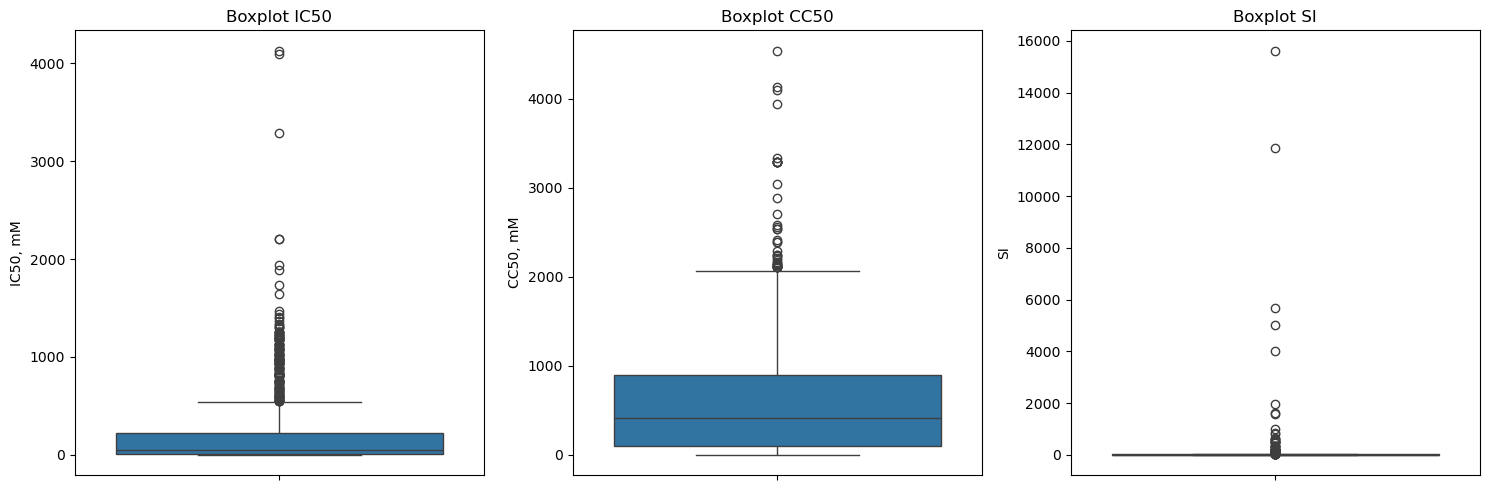

In [15]:
titles_box = ['Boxplot IC50', 'Boxplot CC50', 'Boxplot SI']

# Построение boxplot'ов
plt.figure(figsize=(15, 5))

for i, (col, title) in enumerate(zip(target_cols, titles_box), 1):
    plt.subplot(1, len(target_cols), i)
    sns.boxplot(y=df[col])
    plt.title(title)
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [21]:
df_cleaned = df.copy()

X_scaled = StandardScaler().fit_transform(df_cleaned)

iso = IsolationForest(
        contamination=0.02,
        n_estimators=200,
        max_samples="auto",
        random_state=42
      )
iso.fit(df)

# Фильтруем только "нормальные" строки
outlier_mask = iso.predict(X_scaled) == 1
n_outliers = (~outlier_mask).sum()

# Обновляем df_cleaned
df_cleaned = df_cleaned[outlier_mask].reset_index(drop=True)

print(f"Удалено выбросов: {n_outliers}")
print(f"Осталось строк в df_cleaned: {df_cleaned.shape[0]}")

Удалено выбросов: 21
Осталось строк в df_cleaned: 980


C:\Users\belrs\anaconda3\envs\tf_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


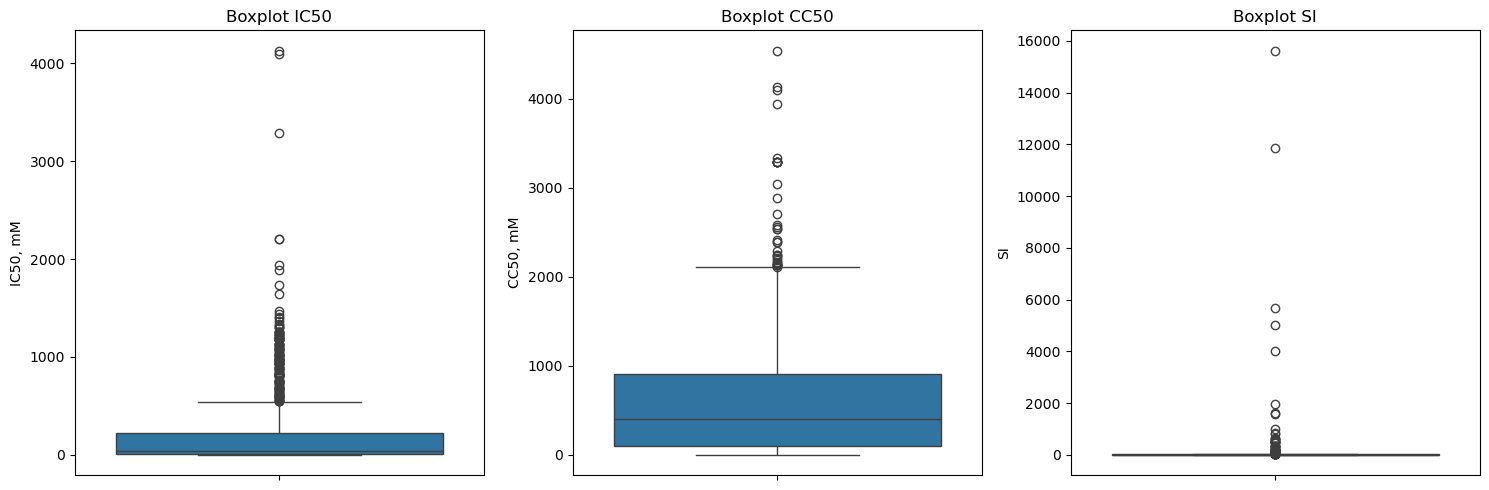

In [23]:
plt.figure(figsize=(15, 5))

for i, (col, title) in enumerate(zip(target_cols, titles_box), 1):
    plt.subplot(1, len(target_cols), i)
    sns.boxplot(y=df_cleaned[col])
    plt.title(title)
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [25]:
df_cleaned.to_csv("df_cleaned.csv", index=False)
print("Сохранено в df_cleaned")

Сохранено в df_cleaned
